In [2]:
import numpy as np
import pandas as pd
import cv2
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet121
import tensorflow as tf
import sklearn

In [15]:
csv_file_path = '../DL_for_Hin_Chest_X_Ray/Data_Entry_2017_filtered_2.csv'
# csv_file_path = '../DL_for_Hin_Chest_X_Ray/HIN_archive/Data_Entry_2017.csv'
df = pd.read_csv(csv_file_path)

IMAGE_DIR = "../DL_for_Hin_Chest_X_Ray/HIN_archive/images/"
ALL_LABELS = sorted(df["Finding Labels"].str.split("|").explode().unique())
ALL_LABELS_WITHOUT_NO = [l for l in ALL_LABELS if l != "No Finding"]
NUMBER_CLASSES = len(ALL_LABELS)

def preprocess_image(file_path, image_size):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return None
    image = cv2.resize(image, (image_size, image_size))
    return image

def prepare_data(df, image_size, image_dir=IMAGE_DIR):
    images = []
    labels = []
    
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(image_dir, row["Image Index"])
        image = preprocess_image(image_path, image_size)
        
        if image is not None:
            images.append(image)

            current_label = np.zeros(NUMBER_CLASSES, dtype=int)
        
            if row["Finding Labels"] != "No Finding":
                indices = [i for i, label in enumerate(ALL_LABELS_WITHOUT_NO) if label in sorted(row["Finding Labels"].split("|"))]
                for idx in indices:
                    if 0 <= idx < NUMBER_CLASSES:
                        current_label[idx] = 1
            else:
                current_label[NUMBER_CLASSES - 1] = 1
            labels.append(current_label)
    
    images = np.array(images).reshape(-1, image_size, image_size)
    images = np.repeat(images[..., np.newaxis], 3, axis=-1) #rgb
    
    labels = np.array(labels)
    
    return images, labels

In [16]:
def create_resnet_model(image_size):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3), pooling=None)
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(2048, (1, 1), activation='relu')) # Transition Layer
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(NUMBER_CLASSES, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[AUC(multi_label=True)])
    return model

In [17]:
def normalize_image(img, label):
    img = tf.cast(img, np.float32) / 255.0
    return img, label

def create_train_dataset(images_train, labels_train, batch_size=16):
    train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
    train_dataset = train_dataset.map(normalize_image)
    train_dataset = train_dataset.shuffle(buffer_size=100)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    train_dataset = train_dataset.repeat()
    return train_dataset

def create_val_dataset(images_val, labels_val, batch_size=16):
    val_dataset = tf.data.Dataset.from_tensor_slices((images_val, labels_val))
    val_dataset = val_dataset.map(normalize_image)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
    return val_dataset

In [18]:
def evaluate_model(model, images_test, labels_test, batch_size=16):

    images_test = tf.cast(images_test, np.float32) / 255.0
    
    predictions = model.predict(images_test, batch_size=batch_size)
    
    auc_per_class = []
    
    for class_idx in range(NUMBER_CLASSES):
        true_labels_class = labels_test[:, class_idx]
        
        auc = sklearn.metrics.roc_auc_score(true_labels_class, predictions[:, class_idx])
        auc_per_class.append(auc)
        
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels_test, axis=1)
    balanced_accuracy = sklearn.metrics.balanced_accuracy_score(true_classes, predicted_classes)
    accuracy = sklearn.metrics.accuracy_score(true_classes, predicted_classes)
    
    return auc_per_class, balanced_accuracy, accuracy

In [ ]:
NUMBER_OF_IMAGES = 10000
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS_TO_TEST = 150
MODEL_PATH = 'models/resnet_5/'
images_test_list = {}
labels_test_list = {}

for run in range(3, 5):     

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    images, labels = prepare_data(df[:NUMBER_OF_IMAGES], IMAGE_SIZE)
    images_train, images_val, labels_train, labels_val = sklearn.model_selection.train_test_split(images, labels, random_state=42, test_size=0.2)
    images_test, labels_test = prepare_data(df[-(int(NUMBER_OF_IMAGES / 5)):], IMAGE_SIZE)
    images_test_list[run] = images_test
    labels_test_list[run] = labels_test
    
    with open(f"{MODEL_PATH}{run}/images_test.pkl", "wb") as file:
        pickle.dump(images_test, file)
    with open(f"{MODEL_PATH}{run}/labels_test.pkl", "wb") as file:
        pickle.dump(labels_test, file)
    
    train_dataset = create_train_dataset(images_train, labels_train)
    val_dataset = create_val_dataset(images_val, labels_val)
        
    steps_per_epoch = len(images_train) // BATCH_SIZE
    validation_steps = len(images_val) // BATCH_SIZE
    
    checkpoint_callback = ModelCheckpoint(
        MODEL_PATH + str(run) +'/epoch_{epoch}.keras',
        save_freq=steps_per_epoch * 5,
        save_best_only=False
    )
    
    reduceLR_callback = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, #0.2 in resnet_4
        patience=5,
        min_lr=1e-6
    )
    
    model = create_resnet_model(IMAGE_SIZE)
    
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS_TO_TEST,
        validation_data=val_dataset,
        validation_steps=validation_steps,
        callbacks=[checkpoint_callback, reduceLR_callback]
    )
    
    with open(f"{MODEL_PATH}{run}/history.pkl", "wb") as file:
        pickle.dump(history, file)
    with open(f"{MODEL_PATH}images_test_list.pkl", "wb") as file:
        pickle.dump(images_test_list, file)
    with open(f"{MODEL_PATH}labels_test_list.pkl", "wb") as file:
        pickle.dump(labels_test_list, file)

In [19]:
evaluations = {} 
images_test_list = []
labels_test_list = []

for run in range(0, 2):

    with open(f'{MODEL_PATH}{run}/images_test.pkl', 'rb') as file:
        images_test = pickle.load(file)
    with open(f'{MODEL_PATH}{run}/labels_test.pkl', 'rb') as file:
        labels_test = pickle.load(file)
    
    images_test_list.append(images_test)
    labels_test_list.append(labels_test)
    
    
    for epoch in tqdm(range(5, EPOCHS_TO_TEST + 1, 5)):
        model_path = f'{MODEL_PATH}{run}/epoch_{epoch}.keras'
        
        if os.path.exists(model_path):
            model = tf.keras.models.load_model(model_path)
            
            if not evaluations.get(epoch):
                evaluations[epoch] = []
            
            evaluations[epoch].append(evaluate_model(model, images_test, labels_test, 16))
        else:
            print(f"Run {run}: Model for epoch {epoch} not found!")
    # print(f"Run {run}: {evaluations}")
    

with open(f"{MODEL_PATH}images_test_list.pkl", "wb") as file:
    pickle.dump(images_test_list, file)
with open(f"{MODEL_PATH}labels_test_list.pkl", "wb") as file:
    pickle.dump(labels_test_list, file)
with open(f"{MODEL_PATH}evaluations_first.pkl", "wb") as file:
    pickle.dump(evaluations, file)

  0%|          | 0/30 [00:00<?, ?it/s]2025-03-13 18:05:36.197474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step


  3%|▎         | 1/30 [00:19<09:12, 19.07s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step


  7%|▋         | 2/30 [00:33<07:41, 16.48s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step


 10%|█         | 3/30 [00:47<06:57, 15.46s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step


 13%|█▎        | 4/30 [01:02<06:27, 14.90s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step


 17%|█▋        | 5/30 [01:17<06:13, 14.95s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step


 20%|██        | 6/30 [01:33<06:12, 15.52s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step


 23%|██▎       | 7/30 [01:48<05:53, 15.38s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step


 27%|██▋       | 8/30 [02:04<05:38, 15.38s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step


 30%|███       | 9/30 [02:18<05:18, 15.19s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step


 33%|███▎      | 10/30 [02:34<05:06, 15.30s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step


 37%|███▋      | 11/30 [02:48<04:43, 14.90s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step


 40%|████      | 12/30 [03:02<04:22, 14.56s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step


 43%|████▎     | 13/30 [03:16<04:04, 14.40s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step


 47%|████▋     | 14/30 [03:32<03:59, 14.98s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step


 50%|█████     | 15/30 [03:46<03:38, 14.57s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step


 53%|█████▎    | 16/30 [03:59<03:20, 14.32s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step


 57%|█████▋    | 17/30 [04:14<03:06, 14.34s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step


 60%|██████    | 18/30 [04:31<03:00, 15.08s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step


 63%|██████▎   | 19/30 [04:46<02:45, 15.05s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 78ms/step


 67%|██████▋   | 20/30 [05:00<02:29, 14.95s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 70%|███████   | 21/30 [05:14<02:10, 14.53s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step


 73%|███████▎  | 22/30 [05:29<01:57, 14.69s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 77%|███████▋  | 23/30 [05:43<01:41, 14.43s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 80%|████████  | 24/30 [05:56<01:24, 14.16s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 83%|████████▎ | 25/30 [06:10<01:10, 14.02s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step


 87%|████████▋ | 26/30 [06:25<00:56, 14.23s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 90%|█████████ | 27/30 [06:38<00:42, 14.09s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step


 93%|█████████▎| 28/30 [06:52<00:27, 13.93s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 97%|█████████▋| 29/30 [07:06<00:13, 13.95s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step


  0%|          | 0/30 [00:00<?, ?it/s]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


  3%|▎         | 1/30 [00:13<06:43, 13.90s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


  7%|▋         | 2/30 [00:27<06:21, 13.62s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 10%|█         | 3/30 [00:40<06:08, 13.64s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step


 13%|█▎        | 4/30 [00:56<06:14, 14.40s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 17%|█▋        | 5/30 [01:10<05:56, 14.24s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 20%|██        | 6/30 [01:24<05:36, 14.03s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 23%|██▎       | 7/30 [01:38<05:22, 14.00s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 27%|██▋       | 8/30 [01:53<05:16, 14.41s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 30%|███       | 9/30 [02:07<04:59, 14.26s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step


 33%|███▎      | 10/30 [02:21<04:42, 14.10s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step


 37%|███▋      | 11/30 [02:35<04:29, 14.20s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step


 40%|████      | 12/30 [02:54<04:42, 15.68s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step


 43%|████▎     | 13/30 [03:08<04:19, 15.27s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step


 47%|████▋     | 14/30 [03:23<03:59, 14.97s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 50%|█████     | 15/30 [03:37<03:41, 14.77s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step


 53%|█████▎    | 16/30 [03:53<03:32, 15.19s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 57%|█████▋    | 17/30 [04:08<03:15, 15.00s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 60%|██████    | 18/30 [04:22<02:57, 14.83s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 63%|██████▎   | 19/30 [04:37<02:43, 14.83s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 67%|██████▋   | 20/30 [04:53<02:31, 15.12s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 70%|███████   | 21/30 [05:07<02:14, 14.92s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 73%|███████▎  | 22/30 [05:22<01:58, 14.78s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step


 77%|███████▋  | 23/30 [05:36<01:43, 14.81s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step


 80%|████████  | 24/30 [05:55<01:35, 15.84s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 83%|████████▎ | 25/30 [06:09<01:16, 15.38s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 87%|████████▋ | 26/30 [06:24<01:00, 15.20s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 90%|█████████ | 27/30 [06:38<00:44, 14.99s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step


 93%|█████████▎| 28/30 [06:55<00:30, 15.35s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


 97%|█████████▋| 29/30 [07:09<00:15, 15.14s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step


100%|██████████| 30/30 [07:24<00:00, 14.80s/it]


0.012968189054019986


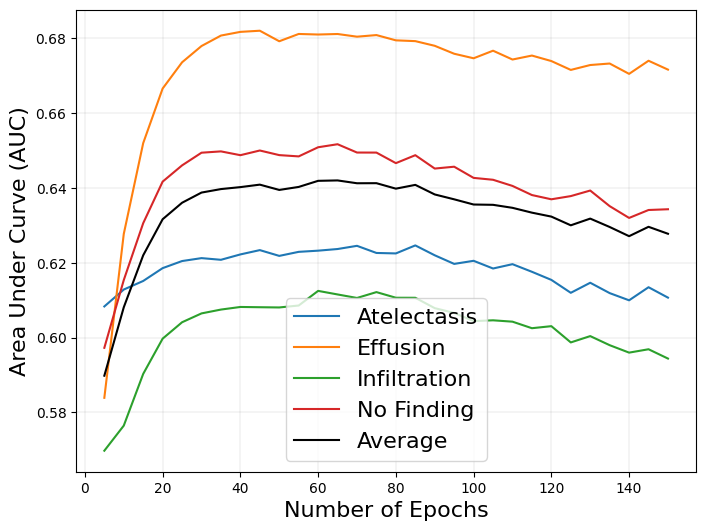

In [19]:
with open('models/resnet_5/evaluations_first3.pkl', 'rb') as file:
    evaluations = pickle.load(file)
with open('models/resnet_2/evaluations.pkl', 'rb') as file:
    evaluations = pickle.load(file)

plt.figure(figsize=(8, 6))

aucs_at_means = []
aucs_at_stds = []
aucs_ef_means = []
aucs_ef_stds = []
aucs_in_means = []
aucs_in_stds = []
aucs_nf_means = []
aucs_nf_stds = []
aucs_All_means = []
aucs_All_stds = []
baccs_means = []
baccs_stds = []
accs_means = []
accs_stds = []


for evals_per_epoch in evaluations.values():
    aucs_at = []
    aucs_ef = []
    aucs_in = []
    aucs_nf = []
    baccs = []
    accs = []
    
    for eval in evals_per_epoch:
        aucs_at.append(eval[0][0])
        aucs_ef.append(eval[0][1])
        aucs_in.append(eval[0][2])
        aucs_nf.append(eval[0][3])
        baccs.append(eval[1])
        accs.append(eval[2])

    aucs_at_means.append(np.mean(aucs_at))
    aucs_at_stds.append(np.std(aucs_at))
    aucs_ef_means.append(np.mean(aucs_ef))
    aucs_ef_stds.append(np.std(aucs_ef))
    aucs_in_means.append(np.mean(aucs_in))
    aucs_in_stds.append(np.std(aucs_in))
    aucs_nf_means.append(np.mean(aucs_nf))
    aucs_nf_stds.append(np.std(aucs_nf))
    aucs_All_means.append(np.mean(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    aucs_All_stds.append(np.std(np.concatenate((aucs_at, aucs_ef, aucs_in, aucs_nf))))
    baccs_means.append(np.mean(baccs))
    baccs_stds.append(np.std(baccs))
    accs_means.append(np.mean(accs))
    accs_stds.append(np.std(accs))
    
average_stds_per_epoch = []
for epoch_stds in zip(aucs_at_stds, aucs_ef_stds, aucs_in_stds, aucs_nf_stds):
    average_stds_per_epoch.append(np.mean(epoch_stds))

overall_average_std = np.mean(average_stds_per_epoch)
print(overall_average_std)


x_values = evaluations.keys()

font_size = 16

# plt.errorbar(x_values, aucs_at_means, yerr=aucs_at_stds, label='Atelectasis', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_ef_means, yerr=aucs_ef_stds, label='Effusion', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_in_means, yerr=aucs_in_stds, label='Infiltration', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_nf_means, yerr=aucs_nf_stds, label='No Finding', fmt='-o', capsize=5)
# plt.errorbar(x_values, aucs_All_means, label='Average', fmt='-o', capsize=5)

plt.plot(x_values, aucs_at_means, label='Atelectasis')
plt.plot(x_values, aucs_ef_means, label='Effusion')
plt.plot(x_values, aucs_in_means, label='Infiltration')
plt.plot(x_values, aucs_nf_means, label='No Finding')
plt.plot(x_values, aucs_All_means, color='black', label='Average')

plt.ylabel("Area Under Curve (AUC)", fontsize=font_size)
plt.xlabel("Number of Epochs", fontsize=font_size)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(fontsize=font_size, loc="lower center")

# plt.savefig("evalsNew/epochTest/noCallback_10000samples_5runs.pdf", bbox_inches='tight', pad_inches=0)

plt.show()